
## Inter-Subject Correlation and Inter-Subject Functional Correlation 
[Contributions](#contributions)

The functional connectivity methods that we used in previous notebooks compared time series of BOLD activity between voxels within participant to infer how different regions of the brain were interacting. However, BOLD activity contains multiple components ([Figure a](#fig1)):
1. Task-based/stimulus-evoked signal that is reliable across participants
2. Intrinsic fluctuations in neural activity that are participant specific
3. Scanner or physiological noise

In this notebook, we will consider methods that combine data across participants to eliminate #2 and #3 when calculating fMRI reliability (intersubject correlation, ISC, [Hasson et al., 2004](https://doi.org/10.1126/science.1089506)) and connectivity (intersubject functional correlation, ISFC, [Simony et al., 2016](https://doi.org/10.1038/ncomms12141)). ISC and ISFC help isolate #1 because it is the only component that ought to be shared across participants.

[Figure b,c](#fig1) show how ISC differs from functional connectivity: rather than correlating brain regions, which preserves participant-specific activity and noise, ISC correlates between the brains of different participants in order to capture only the activity that is shared. In ISC, this correlation is done for every voxel in the brain to the matching voxel in other brains, producing a full brain map. [Figure e](#fig1) shows this as the diagonal of a correlation matrix, where each cell corresponds to a voxel in subject X correlated with the same anatomical voxel in subject Y. In practice, to simplify the computation and the interpretation it is typical for ISC to compare each individual participant with the average of all other participants.

[Figure d](#fig1) shows ISFC: the correlation of every voxel in one participant with every other voxel in another participant (or average of other participants). This is like FCMA except it is between participants rather than within participants. In fact, these analyses use the same computational tricks. ISFC is valuable because it allows us to identify activity coupling in voxels that are not aligned across participants: the off diagonal in [Figure e](#fig1) represents correlations for voxels in different parts of the brain.

<a id="fig1"></a>![alt text](https://media.springernature.com/m685/nature-assets/ncomms/2016/160718/ncomms12141/images/ncomms12141-f1.jpg)

We will use ISC and ISFC to identify brain regions that respond preferentially to narrative stories, rather than to a random assortment of words (replicating Simony et al., 2016). Furthermore, seed-based connectivity analysis does not show differences between resting state, random words, and intact narratives, but ISFC does distinguish between these conditions (Simony et al., 2016). Thus, ISFC shows greater sensitivity to the task than seed-based functional connectivity. 

## Goal of this script
    1. To run intersubject correlation (ISC).
    2. To run intersubject functional correlation (ISFC).  
    3. Use ISFC to examine how a network of brain regions that respond to narrative stimuli.  
 

## Table of Contents

[1. The ISC-ISFC Workflow](#isc_isfc_wkflow)  

[2. ISC](#isc)
>[2.1 The "Pieman" data](#dataset)  
>[2.2 Data file preparation](#data_prep_isc)  
>[2.3 Compute ISC](#isc_compute)  
>[2.4 ISC with statistical tests](#isc_stats)  

[3. ISFC](#isfc)
>[3.1 Parcel the data](#isfc_parcel)   
>[3.2 Compute FC and ISFC](#fc_isfc)

[4. Spatial Correlation](#spat_corr)
>[4.1 Spatial inter-subject correlation](#spatial_isc)  

#### Exercises
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)   [9](#ex9)  
>[Novel contribution](#novel)  

## 1. The ISC-ISFC workflow  <a id="isc_isfc_wkflow"></a>


The following sequence of steps are recommended for successfully running ISC and ISFC using [BrainIAK](http://brainiak.org/). 

1. [**Data Preparation:**](#data_prep_isc) Organize a data directory with fMRI subject data that you want to process. All subjects must be in the same anatomical space for analysis. Also you need to create a whole-brain mask. The outcome of this is an array of anatomically-aligned and temporally-aligned brain data.  
        
2. [**Compute ISC:**](#isc_compute)  The ISC function computes correlations across subjects for corresponding voxels in the mask. It uses the `compute_correlation` function in BrainIAK, which is optimized for fast execution (and was used in FCMA).

3. [**Permutation Test for ISC:**](#isc_stats) Perform statistical analysis to determine significant correlation values for ISC.

4. [**Compute ISFC:**](#isfc_compute) The ISFC function computes correlations for every voxel in one subject with every other voxel averaged across subjects.

5. [**Cluster the ISFC results:**](#clust_isfc) Create clusters based on the correlation values. 

6. [**Perform ISFC permutation:**](#perm) Perform permutation tests to determine the significance of the results.

In [3]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
import matplotlib.pyplot as plt
import seaborn as sns 

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 5 seconds


## 2. ISC  <a id="isc"></a>

### 2.1 The "Pieman" data  <a id="dataset"></a>

For this script we will use the "Pieman" dataset from [Simony et al. (2016)](https://doi.org/10.1038/ncomms12141). A description of the dataset is as follows:

>18 native English speakers were scanned (15 females, ages: 18–31), corresponding to the replication dataset from the Pieman study.  
>Stimuli for the experiment were generated from a 7 min real life story (["Pie Man", Jim O'Grady](https://www.youtube.com/watch?v=3nZzSUDECLo)) recorded at a live storytelling performance (["The Moth" storytelling event](https://themoth.org/), New York City). Subjects listened to the story from beginning to end (intact condition).
>In addition, subjects listened to scrambled versions of the story, which were generated by dividing the original stimulus into segments of different timescales (paragraphs and words) and then permuting the order of these segments. To generate the scrambled stimuli, the story was segmented manually by identifying the end points of each word and paragraph. Two adjacent short words were assigned to a single segment in cases where we could not separate them. Following segmentation, the intact story was scrambled at two timescales: short—‘words’ (W; 608 words, 0.7±0.5 s each) and long—‘paragraphs’ (P; 11 paragraphs, 38.1±17.6 s each). Laughter and applause were classified as single word events (4.4% of the words). Twelve seconds of neutral music and 3 s of silence preceded, and 15 s of silence followed, each playback in all conditions. These music and silence periods were discarded from all analyses.

More details about the experiment may be accessed in the methods section of the paper.

### 2.2 Data File Preparation <a id="data_prep_isc"></a>


**Loading and preparing the data:**

BrainIAK has methods to efficiently load data. We have used some of these functions in previous notebooks.

> *load_images:* reads data from all subjects in a list that you provide. This is like the function load_images_from_dir but here we specify the names manually. 

> *load_boolean_mask:* Create a binary mask from a brain volume

> *mask_images:* Loads the brain images and masks them with the mask provided

> *image.MaskedMultiSubjectData.from_masked_images:* Creates a list of arrays, with each item in the list corresponding to one subject's data. This data format is accepted by the BrainIAK ISC and ISFC function.

In [6]:
# Set up experiment metadata

from utils import pieman2_dir, results_path
print('Data directory is: %s' % pieman2_dir)

dir_mask = os.path.join(pieman2_dir, 'masks/')
mask_name = os.path.join(dir_mask, 'avg152T1_gray_3mm.nii.gz')
all_task_names = ['word', 'intact1']
all_task_des = ['word level scramble', 'intact story']
n_subjs_total = 18
group_assignment_dict = {task_name: i for i, task_name in enumerate(all_task_names)}

# Where do you want to store the data
dir_out = results_path + 'isc/'
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    print('Dir %s created ' % dir_out)

Data directory is: /Users/aratzan/Downloads/brainiak_datasets/Pieman2


### Helper functions

We provide helper functions to load the data.

<div class="alert alert-block alert-warning">
<strong>Memory limits</strong> Be aware this is going to be run on 18 participants and may push the limits of your memory and computational resources if you are on a laptop. If you want to run it on fewer participants to protect memory, change `n_subjs` to be lower (e.g. 10); however, the anticipated results may not generalize to lower sample sizes.
</div>

In [7]:
# Reduce the number of subjects per condition to make this notebook faster 
upper_limit_n_subjs = 12

def get_file_names(data_dir_, task_name_, verbose = False):
    """
    Get all the participant file names
    
    Parameters
    ----------
    data_dir_ [str]: the data root dir
    task_name_ [str]: the name of the task 
    
    Return
    ----------
    fnames_ [list]: file names for all subjs
    """
    c_ = 0 
    fnames_ = []
    # Collect all file names 
    for subj in range(1, n_subjs_total): 
        fname = os.path.join(
            data_dir_, 'sub-%.3d/func/sub-%.3d-task-%s.nii.gz' % (subj, subj, task_name_))
        
        # If the file exists
        if os.path.exists(fname):
            
            # Add to the list of file names 
            fnames_.append(fname)
            if verbose: 
                print(fname)
            c_+= 1
            if c_ >= upper_limit_n_subjs: 
                break
    return fnames_

In [33]:
"""load brain template"""

# Load the brain mask
brain_mask = io.load_boolean_mask(mask_name)

# Get the list of nonzero voxel coordinates
coords = np.where(brain_mask)

# Load the brain nii image
brain_nii = nib.load(mask_name)

In [34]:
"""load bold data"""

# load the functional data 
fnames = {}
images = {}
masked_images = {}
bold = {}
group_assignment = []
n_subjs = {}

for task_name in all_task_names: 
    fnames[task_name] = get_file_names(pieman2_dir, task_name)
    images[task_name] = io.load_images(fnames[task_name]) 
    masked_images[task_name] = image.mask_images(images[task_name], brain_mask) 
    # Concatenate all of the masked images across participants  
    bold[task_name] = image.MaskedMultiSubjectData.from_masked_images(
        masked_images[task_name], len(fnames[task_name])
    )
    # Convert nans into zeros
    bold[task_name][np.isnan(bold[task_name])] = 0
    # compute the group assignment label 
    n_subjs_this_task = np.shape(bold[task_name])[-1]
    group_assignment += list(
        np.repeat(group_assignment_dict[task_name], n_subjs_this_task)
    )
    n_subjs[task_name] = np.shape(bold[task_name])[-1]
    print('Data loaded: {} \t shape: {}' .format(task_name, np.shape(bold[task_name])))

Data loaded: word 	 shape: (300, 98508, 9)
Data loaded: intact1 	 shape: (300, 98508, 12)


**Exercise 1:**<a id="ex1"></a> Inspect the data and report on the following details.
- Brain template 
 - Report the shape of `brain_nii`, `brain_mask`
 - Visualize `brain_nii` and `brain_mask` by plotting the 30th slice along the Z dimension.
 - Describe what `coords` refers to  
 - Visualize `coords` with a 3d plot. For this, only plot every 10th point, otherwise the plot will be slow to load. 
- Brain data 
 - Inspect the shape of `bold`. How many subjects do we have for each task condition? Do different subjects have the same number of TRs/voxels?

brain mask shape:  (61, 73, 61)
brain_nii shape:  (61, 73, 61)


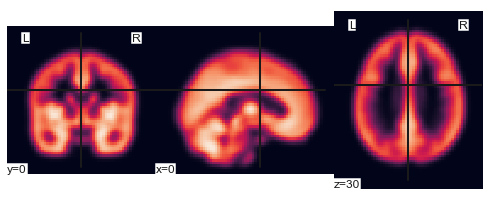

In [36]:
#brain nii and brain mask shape 
print("brain mask shape: ", brain_mask.shape)
print("brain_nii shape: ", brain_nii.shape) 

plotting.plot_img(brain_nii, cut_coords=[0, 0, 30]) #cut at 30th slice of z-coord



98508
(array([ 4,  4,  4, ..., 57, 57, 57]), array([27, 28, 28, ..., 34, 34, 34]), array([24, 22, 23, ..., 23, 24, 25]))


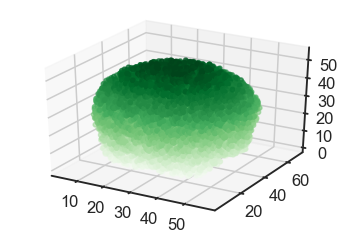

In [37]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
#3D plot of the voxels

print(len(coords[0])) #represents coordinates of each non-zero voxel (x, y, z)
#100,000 coords (many many voxels!)

print(coords)

fig = plt.figure()
ax = plt.axes(projection='3d')

zdata = coords[2][0::10]
xdata = coords[0][0::10]
ydata = coords[1][0::10]

ax.scatter(xdata, ydata, zdata, c=zdata, cmap='Greens')


### 2.3 Compute ISC <a id="isc_compute"></a>

ISC is the correlation of each voxel's time series for a participant with the corresponding (anatomically aligned) voxel time series in the average of the other participants' brains. BrainIAK has functions for computing ISC by feeding in the concatenated participant data. 

This will take about 10 minutes to complete.

In [38]:
# run ISC, loop over conditions 
isc_maps = {}
for task_name in all_task_names:
    isc_maps[task_name] = isc(bold[task_name], pairwise=False)
    print('Shape of %s condition:' % task_name, np.shape(isc_maps[task_name]))

Shape of word condition: (9, 98508)
Shape of intact1 condition: (12, 98508)


The output of ISC is a voxel by participant matrix (showing the result of each individual with the group). Below we will visualize the ISC matrix for one participant and condition back on to the brain to see where activity is correlated between participants.

In [39]:
# set params 
subj_id = 0
task_name = 'intact1'
save_data = False

#for each task load in bold data of that task and compute ISC

#coords is shape 3 x 98508 

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
print(isc_vol.shape) #61 x 73 x 61, for one participant 

# Map the ISC data for the first participant into brain space
isc_vol[coords] = isc_maps[task_name][subj_id, :]

# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# Save the ISC data as a volume
if save_data: 
    isc_map_path = os.path.join(dir_out, 'ISC_%s_sub%.2d.nii.gz' % (task_name, subj_id))
    nib.save(isc_nifti, isc_map_path)

(61, 73, 61)


Text(0.5, 1.0, 'ISC map for subject 0, task = intact1')

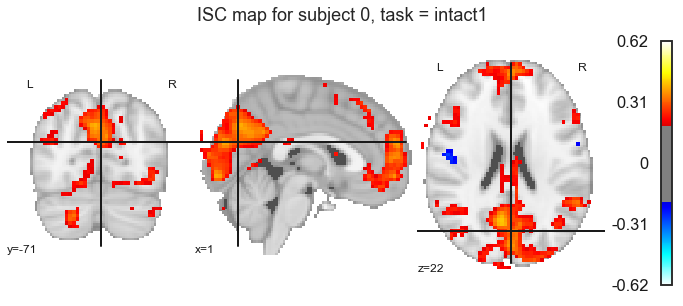

In [40]:
# Plot the data as a statmap
threshold = .2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax
)
ax.set_title('ISC map for subject {}, task = {}' .format(subj_id,task_name)) 

**Exercise 2:** <a id="ex2"></a> Visualize the averaged ISC map (averaged across participants) for each task. 
- Make the averaged ISC map for the two conditions (intact, word-scrambled). 
- Visualize them using `plotting.plot_stat_map`. 

Make sure to compare the two maps using the same xyz cut, threshold and vmax. 

In [59]:
# Insert code here
print(all_task_names)
print(n_subjs) 

#word is scrambled, 9 total
task_name = 'word'
isc_vol_word = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
# use np.mean()

isc_vol_word[coords] = np.mean(isc_maps[task_name], axis = 0)
print(isc_vol_word.shape)
isc_nifti_word = nib.Nifti1Image(isc_vol_word, brain_nii.affine, brain_nii.header)

#intact1 is intact, 12 total 
task_name = 'intact1'
isc_vol_intact = np.zeros(brain_nii.shape)
isc_vol_intact[coords] = np.mean(isc_maps[task_name], axis = 0)
print(isc_vol_intact.shape)
isc_nifti_intact = nib.Nifti1Image(isc_vol_intact, brain_nii.affine, brain_nii.header)





['word', 'intact1']
{'word': 9, 'intact1': 12}
(61, 73, 61)
(61, 73, 61)


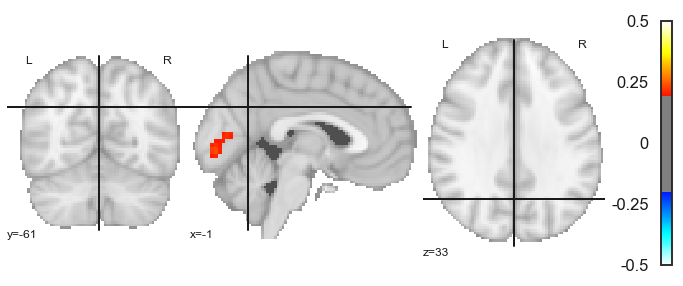

In [70]:
threshold = 0.2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti_word, 
    threshold=threshold, 
    axes=ax, 
    cut_coords = (-1, -61, 33)
)


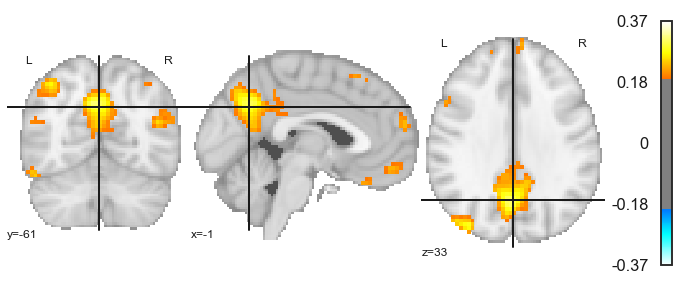

In [69]:
threshold = .2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti_intact, 
    threshold=threshold, 
    axes=ax,
    cut_coords = (-1, -61, 33)
)

This analysis was performed in volumetric space; however, nilearn makes it easy to compare this data in surface space (assuming the alignment to MNI standard is excellent). Here's an example of surface plot.

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

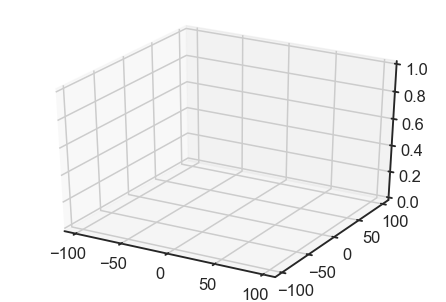

In [93]:
# set some plotting params 
subj_id = 0 
task_name = 'intact1'
threshold = .2 
view = 'medial'

# get a surface
fsaverage = datasets.fetch_surf_fsaverage5()

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = isc_maps[task_name][subj_id, :]
# make a nii image of the isc map 
isc_intact_1subj = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# make "texture" 
texture = surface.vol_to_surf(isc_intact_1subj, fsaverage.pial_left) 

# # plot 
title_text = ('Avg ISC map, {} for one participant'.format(task_name))
surf_map = plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture, 
    hemi='left', view=view, 
    title= title_text, 
    threshold=threshold, cmap='RdYlBu_r', 
    colorbar=True,
    bg_map=fsaverage.sulc_left
)



**Exercise 3:** <a id="ex3"></a> Visualize the averaged ISC map using surface plot. 
- Visualize the average ISC maps using `plotting.plot_surf_stat_map` for:
    - both conditions
    - both `medial` view and `lateral` views 
    
Make sure you are using the same threshold and vmax for all plots. 

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

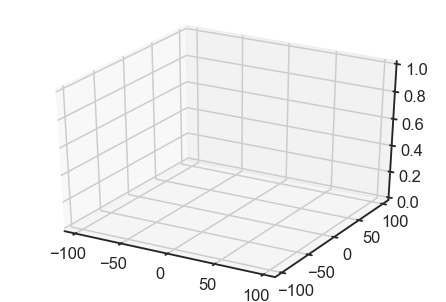

In [84]:
# Insert code here

texture = surface.vol_to_surf(isc_nifti_word, fsaverage.pial_right) 

plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere', colorbar=True,
                            threshold=1., bg_map=fsaverage.sulc_right)



In [ ]:

texture = surface.vol_to_surf(isc_nifti_intact, fsaverage.pial_right) 

plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere', colorbar=True,
                            threshold=1., bg_map=fsaverage.sulc_right)


**Exercise 4:** <a id="ex4"></a> Compare the averaged ISC map for the two task conditions. What are some brain regions showing stronger correlation in the intact story condition (vs. the word-level scramble condition)? What does this tell us about the processing of language? 

Hint: The following [paper](https://doi.org/10.1523/JNEUROSCI.3684-10.2011) this work comes from will help.

**A:** 
Far more brain activation in intact condition... early auditory areas always responsive and higher level temporal structures became increasingly dependent on coherence. (could be specifically useful for foreign language learning conditions) 



### 2.4 ISC with statistical tests  <a id="isc_stats"></a>

BrainIAK provides several nonparametric statistical tests for ISC analysis ([Nastase et al., 2019](https://doi.org/10.1101/600114)). Nonparametric tests are preferred due to the inherent correlation structure across ISC values—each subject contributes to the ISC of other subjects, violating assumptions of independence required for standard parametric tests (e.g., t-test, ANOVA). We will use the permutation test below.

#### 2.4.1 Permutation test
Permutation tests are used to compute a null distribution of values. We have used permutation tests in previous notebooks and the steps outlined here are similar to what was done in prior notebooks with one small change, incorporating the group of subjects to compute the ISC:

1. Prepare the data. Here we have two conditions (intact and word_scramble), so we compute ISC for both conditions and concatenate the data for these two conditions for all subjects.  
> We use leave-one-subject-out (`pairwise=False`) to compute ISC and then use these correlations `isc_maps_all_tasks` to compute statistics.  

2. We are going to permute the condition label for each subject to simulate the randomization of conditions. To do this, we first need to assign subjects to the correct experimental conditions that they were in. We have prepared such a list of assignments when we loaded the data and stored the information in the variable: `group_assignment`.
 
3. The next steps are executed internally in BrainIAK in the function `permutation_isc`:    
> - For each permutation iteration: 
>> - BrainIAK permutes the group assignment for each subject.  
>> - A mean of the ISC values is then computed for this shuffled 
group for each condition.   
>> -  A difference of group means is computed between each condition.  
> - The difference values for all iterations is collected and forms the null distribution.   
4. Finally, we pick a threshold value that corresponds to `p` percent of this distribution.  

`permutation_isc` returns the actual observed ISC values, p-values, and optionally the resampling distribution.

In [94]:
# Concatenate ISCs from both tasks
isc_maps_all_tasks = np.vstack([isc_maps[task_name] for
                                task_name in all_task_names])

print('group_assignment: {}'.format(group_assignment))
print('isc_maps_all_tasks: {}' .format(np.shape(isc_maps_all_tasks)))

group_assignment: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
isc_maps_all_tasks: (21, 98508)


In [95]:
# permutation testing
n_permutations = 1000
summary_statistic='mean'

observed, p, distribution = permutation_isc(
    isc_maps_all_tasks, 
    pairwise=False,
    group_assignment=group_assignment, 
    summary_statistic=summary_statistic,
    n_permutations=n_permutations
)

p = p.ravel()
observed = observed.ravel()

print('observed:{}'.format(np.shape(observed)))
print('p:{}'.format(np.shape(p)))
print('distribution: {}'.format(np.shape(distribution)))

observed:(98508,)
p:(98508,)
distribution: (1000, 98508)


**Exercise 5:** <a id="ex5"></a> Interpret the results from the permutation test. 

- What's the logic of the permutation test? 
- What are the outputs `observed`, `p`, `distribution` 
- Visualize the correlation contrast map (e.g. intact > word-level scramble) with a significance criterion (e.g. p < .005). Which region(s) showed higher ISC under the chosen contrast? 

**A:**

Logic: the logic of a permutation distribution is to run permuted ISC tests and assign a null distribution to each sample (tells you the probability of null hypothesis being true). The permutation happens on the group assignment of each subject and ISC is computed intra/intergroup. 

observed is the ISC output, p-value is stat significance, distribution is the null distribution



In [110]:
#plot stat map with p-value threshold of .005 
isc_all = []

for i in range(21):
    isc_all.append(isc_maps_all_tasks[i][(p < .005)])
    
isc_all = np.asarray(isc_all)

print(isc_all.shape)

#first load ISC data 
#then retain only values that are less than .005
#display vals 

(21, 15848)


## 3. ISFC  <a id="isfc"></a>

The goal of ISFC is to find coupling between brain regions across participants. For example the angular gyrus in subject 1 could be correlated to the pre-frontal cortex in subject 2, if they share some cognitive state. For completely random cognitive states across these two subjects, the correlation should be zero. ISFC helps us identify such commonalities across subjects.

In this section, we will compare functional connectivity vs. ISFC on the Pieman data. Whereas FC is computed within individuals, ISFC is computed between individuals. Hence the only correlations that should be robust in ISFC are those that are present across individuals. At the end of the exercises, you will qualitatively replicate [Simony et al. (2016)](https://doi.org/10.1038/ncomms12141), showing that ISFC is sensitive to the cognitive state of the participants.

### 3.1 Parcel the data  <a id="isfc_parcel"></a>

ISFC in voxel space is very computationally intensive, so for this notebook we will divide the brain into a smaller number of parcels. We are going to use predefined ROI masks to select the voxels.

number of voxels:	 (98508, 12)
number of parcels:	 96


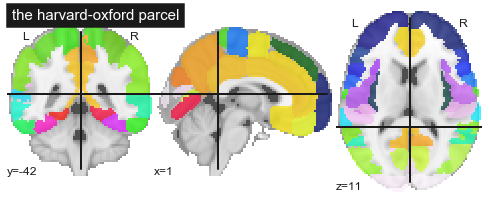

In [111]:
# load a parcel
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', symmetric_split=True)
plotting.plot_roi(atlas.maps, title='the harvard-oxford parcel')

n_regions = len(atlas.labels)-1 # rm background region 
n_TRs = np.shape(bold[task_name])[0]

print('number of voxels:\t {}'.format(np.shape(bold[task_name][1])))
print('number of parcels:\t {}'.format(n_regions))

Convert the bold data into ROI parcels

In [113]:
# Get a masker for the atlas 
masker_ho = NiftiLabelsMasker(labels_img=atlas.maps)

# Transform the data to the parcel space
bold_ho = {
    task_name:np.zeros((n_TRs, n_regions, n_subjs[task_name])) 
    for task_name in all_task_names}

# Collect all data 
row_has_nan = np.zeros(shape=(n_regions,), dtype=bool)
for task_name in all_task_names:
    for subj_id in range(n_subjs[task_name]):
        
        # get the data for task t, subject s 
        nii_t_s = nib.load(fnames[task_name][subj_id])
        bold_ho[task_name][:,:,subj_id] = masker_ho.fit_transform(nii_t_s)
        
        # figure out missing rois
        row_has_nan_ = np.any(np.isnan(bold_ho[task_name][:,:,subj_id]),axis=0)
        row_has_nan[row_has_nan_] = True                

# Figure out which ROI has missing values
roi_select = np.logical_not(row_has_nan)
n_roi_select = np.sum(roi_select)
rois_filtered = np.array(atlas.labels[1:])[roi_select]
bold_ho_filtered = {
    task_name:np.zeros((n_TRs, n_roi_select, n_subjs[task_name])) 
    for task_name in all_task_names
}

# Remove ROIs with missing values
for task_name in all_task_names:
    for subj_id in range(n_subjs[task_name]):
        bold_ho_filtered[task_name][:,:,subj_id] = bold_ho[task_name][:,roi_select,subj_id]
              
print('ROI selected\n {}'.format(rois_filtered))
print('ROI removed due to missing values :( \n {}'.format(np.array(atlas.labels[1:])[row_has_nan]))

ROI selected
 ['Left Insular Cortex' 'Right Insular Cortex'
 'Left Inferior Frontal Gyrus, pars triangularis'
 'Right Inferior Frontal Gyrus, pars triangularis'
 'Left Inferior Frontal Gyrus, pars opercularis'
 'Right Inferior Frontal Gyrus, pars opercularis'
 'Left Superior Temporal Gyrus, anterior division'
 'Right Superior Temporal Gyrus, anterior division'
 'Left Superior Temporal Gyrus, posterior division'
 'Right Superior Temporal Gyrus, posterior division'
 'Left Middle Temporal Gyrus, anterior division'
 'Right Middle Temporal Gyrus, anterior division'
 'Left Middle Temporal Gyrus, posterior division'
 'Right Middle Temporal Gyrus, posterior division'
 'Left Middle Temporal Gyrus, temporooccipital part'
 'Right Middle Temporal Gyrus, temporooccipital part'
 'Right Inferior Temporal Gyrus, posterior division'
 'Left Inferior Temporal Gyrus, temporooccipital part'
 'Right Inferior Temporal Gyrus, temporooccipital part'
 'Left Supramarginal Gyrus, anterior division'
 'Right Supram

### 3.2 Compute FC and ISFC  <a id="fc_isfc"></a>

Here we compute FC and ISFC on the parcellated data. 

In [114]:
# Compute FC
fc_maps = {
    task_name:np.zeros((n_roi_select,n_roi_select)) 
    for task_name in all_task_names
}
for task_name in all_task_names: 
    for subj_id in range(n_subjs[task_name]): 
        fc_maps[task_name] += np.corrcoef(
            bold_ho_filtered[task_name][:,:,subj_id].T
        ) / n_subjs[task_name]
        np.fill_diagonal(fc_maps[task_name], np.nan)     

In [115]:
# Compute ISFC
isfc_maps_ho = {}
for task_name in all_task_names:
    isfc_maps_ho[task_name] = isfc(data=bold_ho_filtered[task_name],
                                   summary_statistic='median',
                                   vectorize_isfcs=False)   

**Exercise 6:** <a id="ex6"></a> Visualize the FC/ISFC matrices, averaged across subjects

- Use `imshow` to visualize the 4 correlation matrices: (FC vs. ISFC) x (word-level scrambled vs. intact story)
- Mark the rows (or columns) with the ROI labels

(65, 65)
(65,)


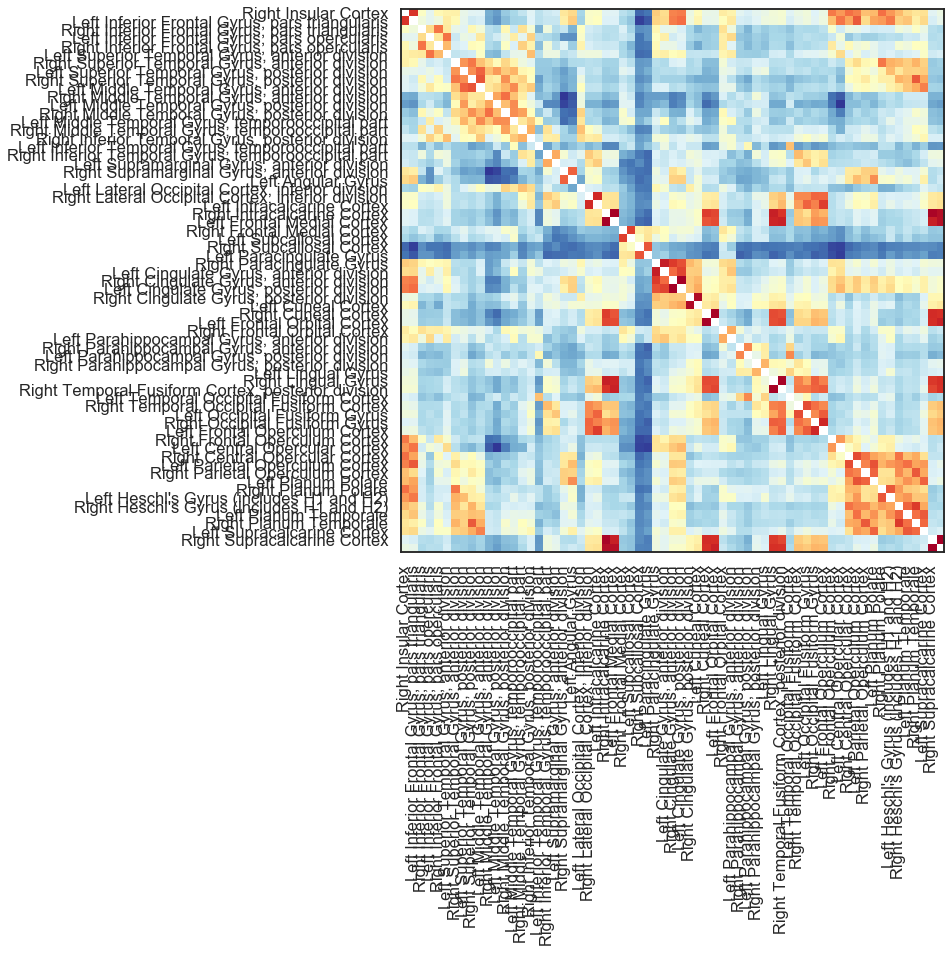

In [142]:
# Insert code here
print(fc_maps['intact1'].shape)
print(rois_filtered.shape)
labels = rois_filtered

fig = plt.figure(figsize=(12,10))

plt.imshow(fc_maps['intact1'], cmap='RdYlBu_r')
plt.yticks(range(len(labels)), labels[1:]);
plt.xticks(range(len(labels)),labels[1:], rotation=90);

#ax.set_xticklabels(labels)
#ax.set_yticklabels(labels)




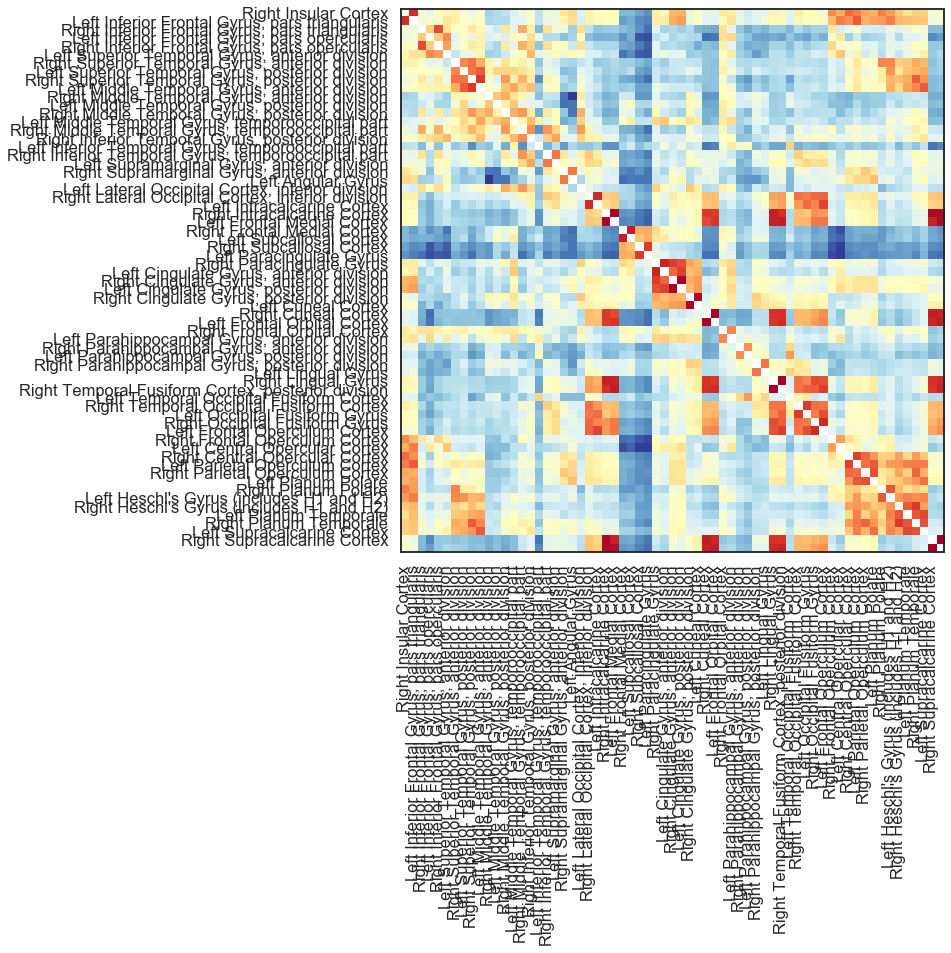

In [143]:
labels = rois_filtered

fig = plt.figure(figsize=(12,10))

plt.imshow(fc_maps['word'], cmap='RdYlBu_r')
plt.yticks(range(len(labels)), labels[1:]);
plt.xticks(range(len(labels)),labels[1:], rotation=90);


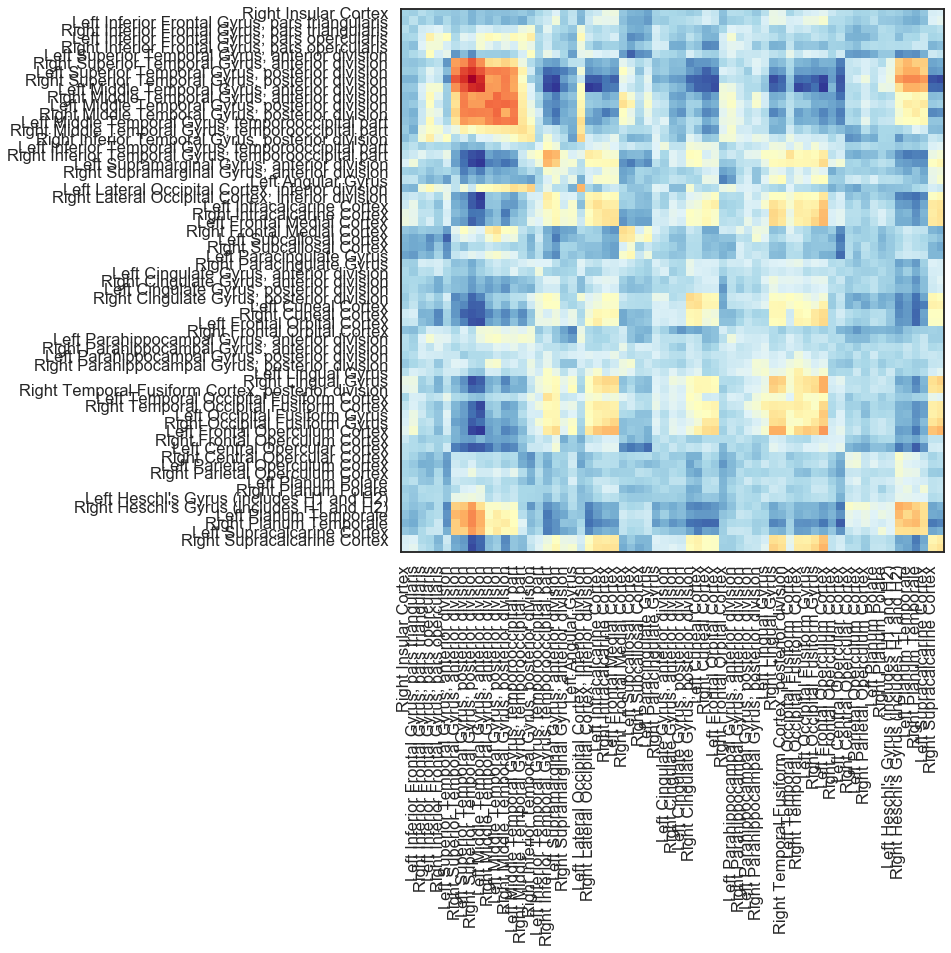

In [146]:
labels = rois_filtered

fig = plt.figure(figsize=(12,10))

plt.imshow(isfc_maps_ho['intact1'], cmap='RdYlBu_r')
plt.yticks(range(len(labels)), labels[1:]);
plt.xticks(range(len(labels)),labels[1:], rotation=90);


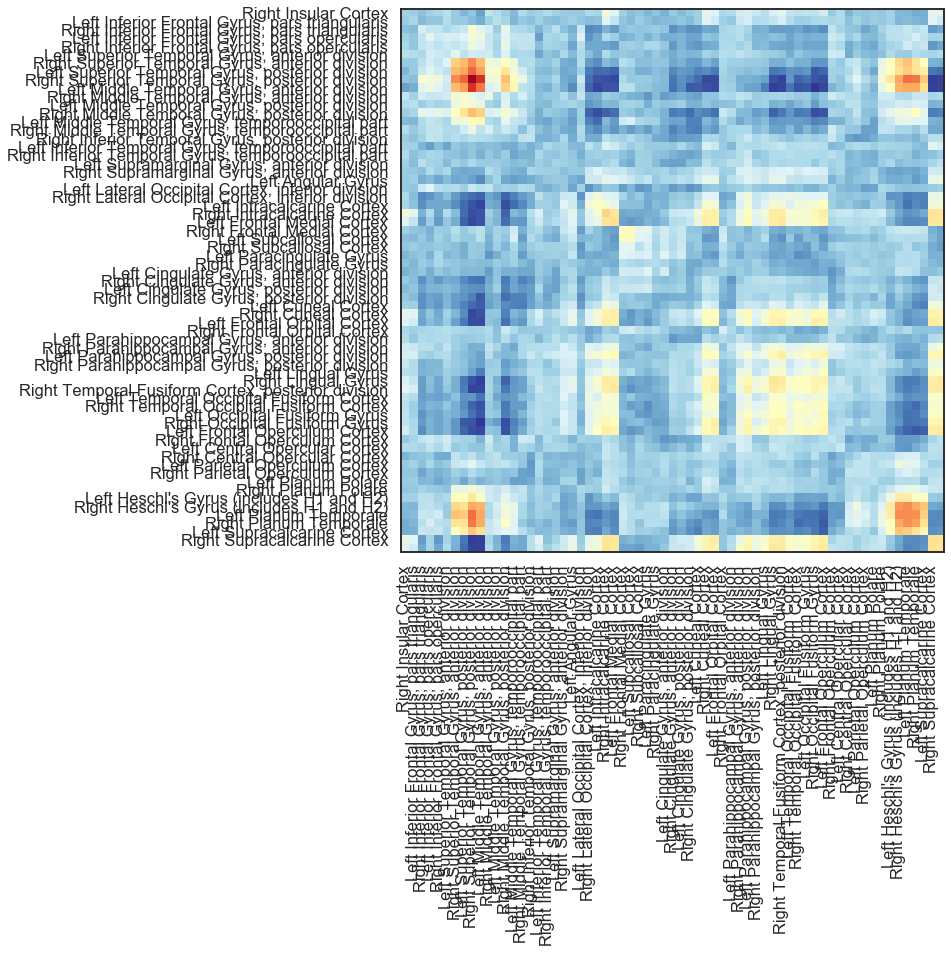

In [147]:
labels = rois_filtered

fig = plt.figure(figsize=(12,10))

plt.imshow(isfc_maps_ho['word'], cmap='RdYlBu_r')
plt.yticks(range(len(labels)), labels[1:]);
plt.xticks(range(len(labels)),labels[1:], rotation=90);


**Exercise 7:** <a id="ex7"></a> Visualize FC/ISFC connectivity strength on glass brains 

- Use `plot_connectome` to visualize the 4 correlation matrices: (FC vs. ISFC) x (word-level scrabled vs. intact story)
- Use common `edge_threshold` for all plots. 

*Hint:* The plot_connectome function takes as an input a correlation matrix (such as the FC one plotted above) and also a set of coordinates that define the XYZ coordinates that corresponds to each column/row of the correlation matrix. In order to get the coordinates of these ROIs, we recommend you use: `plotting.find_parcellation_cut_coords(atlas.maps)[roi_select]`  

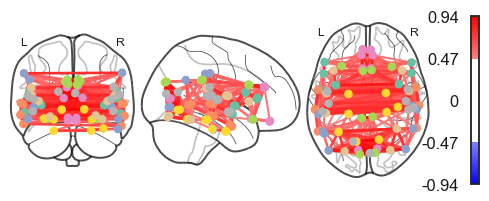

In [150]:
# Insert code here
coords = plotting.find_parcellation_cut_coords(atlas.maps)[roi_select]


plotting.plot_connectome(fc_maps['intact1'], coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

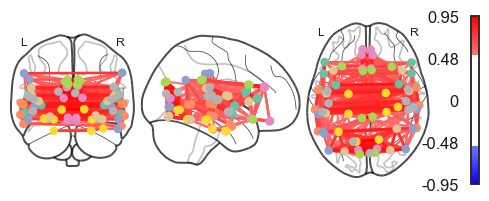

In [151]:
plotting.plot_connectome(fc_maps['word'], coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

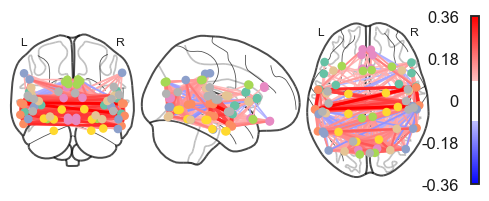

In [152]:
plotting.plot_connectome(isfc_maps_ho['intact1'], coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

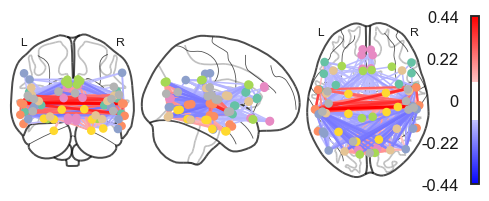

In [153]:
plotting.plot_connectome(isfc_maps_ho['word'], coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

**Exercise 8:** <a id="ex8"></a> Do FC maps look different across conditions? How about ISFC? And why? Hint: consult this [paper](https://doi.org/10.1038/ncomms12141).

**A:** similarity between fc map connectomes is high likely because intrabrain reactions are similar across subjects. 

isfc maps show more negative correlations for the word condition probably because people reactions are not all the same to the randomly worded problem than the intact1 problem. 

(??? can be better explained) 

## 4. Spatial pattern correlation across subjects <a id="spat_corr"></a>


### 4.1 Spatial inter-subject correlation  <a id="spatial_isc"></a>

<br>
We can apply the idea of inter-subject analysis to RSA. So far, ISC is being computed between aligned pairs of voxels across time points and it is commonly referred to as temporal ISC. However, we could instead correlate between aligned pairs of time points across voxels. That is, how does the pattern of activity across voxels for one time point correlate with the average pattern of the other participants at that time point. By doing this for each time point, we can generate a time course of these correlations to observe the general ebb and flow of coupling in brain activity across participants. This can be done simply by transposing the voxel and time dimensions (for a 3-D matrix, this is accomplished with a 90 degree rotation). This is a simple [transposition](https://lihan.me/2018/01/numpy-reshape-and-transpose/). If we have data in the format: (TRs, voxels, subjects), we can use `data.transpose(1,0,2)`, where the indices refer to the dimensions of the array and we will have an array in the format (voxels, TRs, subjects).

#### Compare the two task conditions with spatial ISC 

One way to compare the intact and word_scramble conditions is to plot the correlation values, by TR, for each condition. Again, we can use the same ISC functions from above after transposing the data matrices. 

In [154]:
# Get a list of ROIs. 
roi_mask_path = os.path.join(pieman2_dir,'masks','rois')
all_roi_fpaths = glob.glob(os.path.join(roi_mask_path, '*.nii.gz'))

# Collect all ROIs 
all_roi_names = []
all_roi_nii = {}
all_roi_masker = {}
for roi_fpath in all_roi_fpaths:
    
    # Compute ROI name
    roi_fname = os.path.basename(roi_fpath)
    roi_name = roi_fname.split('.')[0]
    all_roi_names.append(roi_name)
    
    # Load roi nii file 
    roi_nii = nib.load(roi_fpath)
    all_roi_nii[roi_name] = roi_nii
    
    # Make roi maskers
    all_roi_masker[roi_name] = NiftiMasker(mask_img=roi_nii)

print('Path to all roi masks: {}'.format(roi_mask_path))    
print('Here are all ROIs:\n{}'.format(all_roi_names))

Path to all roi masks: /Users/aratzan/Downloads/brainiak_datasets/Pieman2/masks/rois
Here are all ROIs:
['dPCUN', 'MCC', 'IPL_R', 'smPFC', 'aINS_L', 'PMC_L', 'aANG_L', 'HG_L', 'caMTG_L', 'pIFG_L', 'SMG_L', 'dPoCS_L', 'Insular_R', 'aSTG_L', 'vmPFC', 'SFS_L', 'dMFG_R', 'SMA_L', 'HG_R', 'aANG_R', 'vV2', 'mldV2_R', 'IPL_L', 'Insular_L', 'dMFG_L', 'dPreCG_L', 'aMTG_R', 'dPoCS_R', 'SMG_R', 'pMTG_R', 'lOFG_L', 'aPFC', 'LOC_R', 'aOFC_R', 'dPCC', 'aIFG_R', 'vPFC_R', 'SOG_L', 'ldV2_L', 'STC_L', 'pANG_R', 'pMTS_R', 'cMTG_R', 'SFG', 'hV4_L', 'V3a_R', 'DLPFC_R', 'vPCUN', 'aOFC_L', 'aIFG_L', 'V3', 'LOC_L', 'lOFG_R', 'V1', 'DLPFC_L', 'dmPFG', 'aCUN', 'pANG_L', 'STC_R', 'V3a_L', 'hV4_R', 'pMTS_L', 'vMFG_L']


In [155]:
# Make a function to load data for one ROI
def load_roi_data(roi_name): 
    # Pick a roi masker
    roi_masker = all_roi_masker[roi_name]    
    
    # Preallocate 
    bold_roi = {task_name:[] for i, task_name in enumerate(all_task_names)}
    
    # Gather data 
    for task_name in all_task_names:
        for subj_id in range(n_subjs[task_name]):
            
            # Get the data for task t, subject s 
            nii_t_s = nib.load(fnames[task_name][subj_id])
            bold_roi[task_name].append(roi_masker.fit_transform(nii_t_s))
            
        # Reformat the data to std form 
        bold_roi[task_name] = np.transpose(np.array(bold_roi[task_name]), [1,2,0])
    return bold_roi

Compute spatial ISC on some ROIs. 

In [156]:
roi_selected = ['dPCC', 'vPCUN', 'V1']
roi_selected_names = ['dorsal posterior cingulate cortex', 'ventral precuneus', 'primary visual cortex']

# compute sISC for all ROIs 
iscs_roi_selected = []
for j, roi_name in enumerate(roi_selected):
    print(j, roi_name)
    
    # Load data 
    bold_roi = load_roi_data(roi_name)
    
    # Compute isc 
    iscs_roi = {}
    for task_name in all_task_names: 
        iscs_roi[task_name] = isc(np.transpose(bold_roi[task_name], [1,0,2]))
        
    iscs_roi_selected.append(iscs_roi)

0 dPCC
1 vPCUN
2 V1


ValueError: These `style` levels are missing dashes: {6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299}

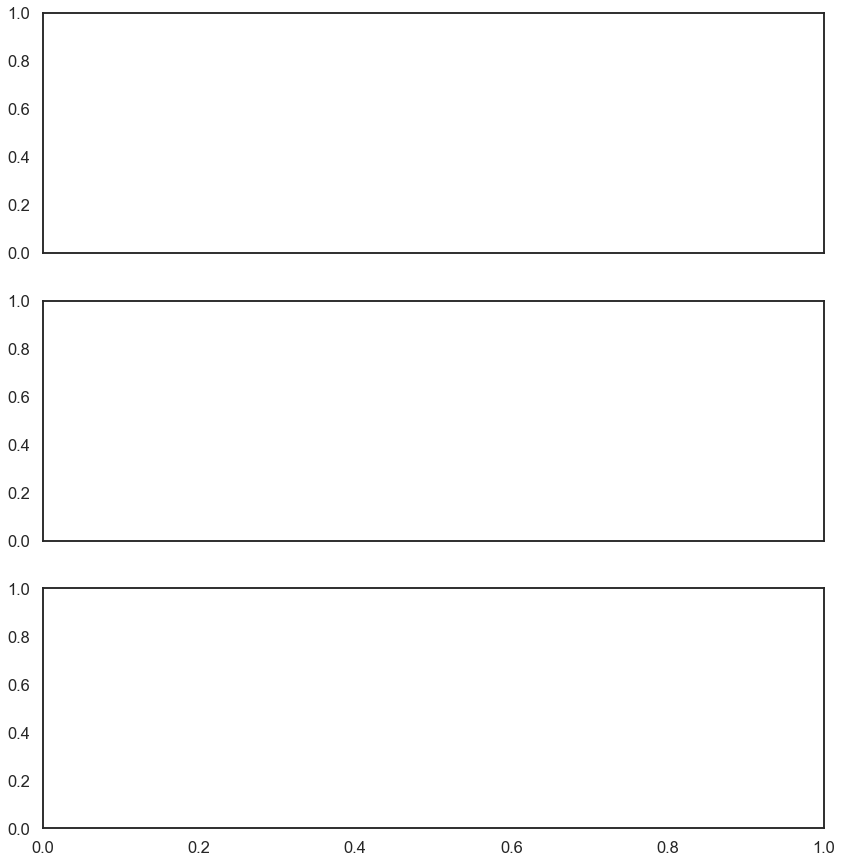

In [163]:
# Plot the spatial ISC over time
col_pal = sns.color_palette(palette='colorblind', n_colors=len(all_task_names))
ci = 95

f, axes = plt.subplots(len(roi_selected), 1, figsize=(14, 5 * len(roi_selected)), sharex=True)

# For each ROI
for j, roi_name in enumerate(roi_selected):
    # For each task 
    for i, task_name in enumerate(all_task_names): 
        sns.lineplot(
            data = iscs_roi_selected[j][task_name], 
            color=col_pal[i], ci=ci, 
            #ax=axes[j]
        )
    f.legend(all_task_des)
    lineplot.despine()

# Label the plot 
for j, roi_name in enumerate(roi_selected):
    axes[j].axhline(0, color='black', linestyle='--', alpha=.3)
    axes[j].set_ylabel('Linear correlation')
    axes[j].set_title('Spatial inter-subject correlation, {}'. format(roi_selected_names[j]))
    
axes[-1].set_xlabel('TRs')

**Exercise 9:**<a id="ex9"></a> Interpret the spatial ISC results you observed above.

**A:**

**Novel contribution:**<a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

Here are some ideas: 

- The ISC package in BrainIAK supports other statistical tests. Study one of them, describe the logic behind it, and re-run the analysis with that test. 
- Conduct a sliding window spatial ISC analysis. 
- Perform some clustering on the ISFC matrices. Use the clustering (instead of the anatomical parcel) to re-analyze the data, and compare ISFC vs. FC across tasks. See [here](http://scikit-learn.org/stable/modules/clustering.html) for a good resource on clustering algorithms.

### Contributions<a id="contributions"></a>

E. Simony and U. Hasson for providing data  
C. Baldassano and C. Chen provided initial code  
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 4/4/18  
S. Nastase enhanced the ISC brainiak module; added the section on statistical testing   
Q. Lu added solutions; switched to S. Nastase's ISC module; replicated Lerner et al 2011 & Simony et al. 2016; added spatial ISC.   
M. Kumar edits to section introductions and explanation on permutation test.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis incorporated edits from cmhn-s19  